In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sbi.utils import pairplot, conditional_pairplot
import pickle
import matplotlib
import torch
from sbi.simulators import simulate_in_batches

import sys
sys.path.append("../")
# from utils import plot_diag, plot_offdiag
from sbi.inference import prepare_for_sbi
# matplotlib.rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('../../.matplotlibrc')
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load literature inference results
with open("../../../results/npe_measured_data_ss50_ep1295.p", "rb") as fh:
    prior, posterior, seed, simulator, density_estimator = pickle.load(fh).values()

AttributeError: Can't get attribute 'default_rule' on <module 'consbi.simulators.rule_simulator' from '/Users/janbolts/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py'>

## Generate samples and data

In [13]:
xo = torch.tensor(simulator.constraints["observables"]).reshape(1, -1)
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]
posterior.set_default_x(xo)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])),
               x_shape=torch.Size([1, 7]))
               

In [54]:
N = 10000
ths = prior.sample((N,))
# thos = torch.ones(1, 3).repeat(1000, 1) 
thos = posterior.sample((N,), x=xo, show_progress_bars=False)

In [55]:
batch_simulator, prior = prepare_for_sbi(simulator, prior)
num_workers = 20

# xs = simulate_in_batches(batch_simulator, ths, num_workers=num_workers, sim_batch_size=50)
xos = simulate_in_batches(batch_simulator, thos, num_workers=num_workers, sim_batch_size=50)

In [41]:
# cross validation results
with open("../../default_rule_benchmark/results/cross_validation_results_default_rule.p", "rb") as fh:
    predictive_samples_lit = pickle.load(fh)["predictive_samples_lit"]

In [42]:
correlation = np.array([[ 1.        , np.nan,  np.nan],
       [-0.28551968,  1.        ,  np.nan],
       [ 0.30403507,  0.82342925,  1.        ]])

conditional_correlation = np.array([[ 1.0000, np.nan,  np.nan],
        [-0.9947,  1.0000,  np.nan],
        [ 0.9966,  0.9975,  1.0000]])

In [43]:
ndims = ths.shape[1]

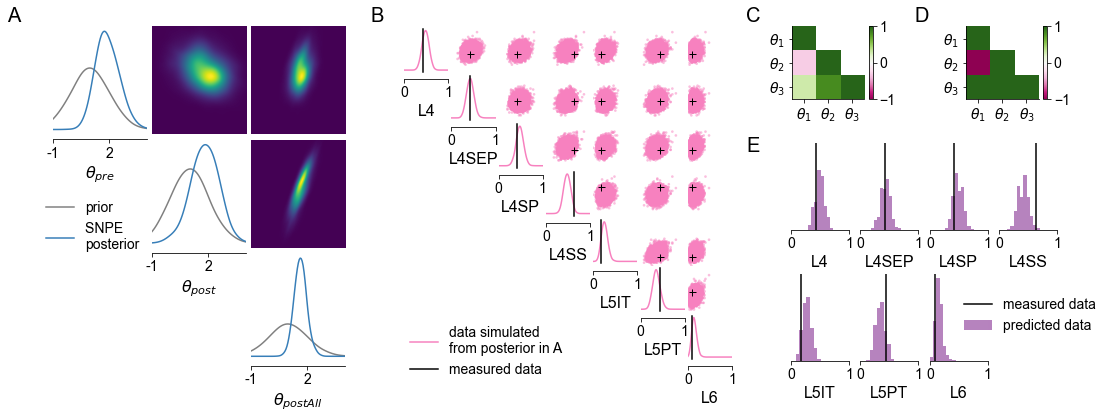

In [60]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 3, wspace=0.2, hspace=0, width_ratios=[.33, .37, .3])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(ndims, ndims, wspace=0.05, hspace=0.05)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# center column
num_plots = 7
center_grid = outer_grid[0, 1].subgridspec(num_plots, num_plots, wspace=0.07, hspace=0)
ax2 = center_grid.subplots()

right_grid = outer_grid[0, 2].subgridspec(2, 1, wspace=0., hspace=0.3, height_ratios=[.25, .75])

corr_subgrid = right_grid[0, 0].subgridspec(1, 2, wspace=.9, hspace=0.0)
ax3 = corr_subgrid.subplots()

cv_subgrid = right_grid[1, 0].subgridspec(2, 4, wspace=0.2, hspace=0.5)
ax4 = cv_subgrid.subplots(sharey=True, sharex=False)

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "SNPE \nposterior"], 
           bbox_to_anchor=(-.2, -.5), 
           loc=2)

fig, ax2 = pairplot(xos[:num_samples], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    hist_diag=dict(bins=10),
                    points_offdiag=posterior_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="scatter",
                    diag="kde",
                    kde_diag=dict(bins=num_bins, bw_method=bw_method),
                    scatter_offdiag=dict(s=7, alpha=0.5),
                    contour_offdiag=dict(levels=[0.99]),
                    samples_colors=[colors[3]],
                    axes=ax2, 
                    fig=fig,
                   )
plt.sca(ax2[0, 0])
plt.legend(["data simulated \nfrom posterior in A", "measured data"], 
           bbox_to_anchor=(-.15, -5.), 
           loc=2)

# Cross validation
for idx, xs in enumerate(predictive_samples_lit):
    
    axi = ax4[0 if idx<4 else 1, idx % 4]
    plt.sca(axi)
    axi.spines["right"].set_visible(False)
    axi.spines["top"].set_visible(False)
    axi.spines["left"].set_visible(False)
    plt.yticks([])
    
    plt.xlim([0, 1])
    plt.xticks([0, 1])
    plt.hist(xs[:, idx].reshape(1, -1), bins=10, alpha=0.7, color=colors[5])
    plt.xlabel(obs_labels[idx])
    plt.axvline(x=xo[0, idx], color="k")

ax4[1, -1].set_visible(False)
plt.sca(ax4[1, -2])
plt.legend([r"measured data", "predicted data"], frameon=False,
           bbox_to_anchor=(.94, .3),
           bbox_transform=plt.gcf().transFigure, 
          );

# Correlation matrices
plt.sca(ax3[0])
im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])
plt.yticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])

plt.sca(ax3[1])
im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])
plt.yticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)]);


# Add Letters.
weight = "regular"
fontsize = 20
y = 0.91
fig.text(.09, y, "A", fontsize=fontsize, fontweight=weight)
fig.text(.37, y, "B", fontsize=fontsize, fontweight=weight)
fig.text(.66, y, "C", fontsize=fontsize, fontweight=weight)
fig.text(.79, y, "D", fontsize=fontsize, fontweight=weight);
fig.text(.66, .61, "E", fontsize=fontsize, fontweight=weight);

In [61]:
fig.savefig("figure3_literatureInference_Default_ss50_gaussian.png", dpi=300, bbox_inches='tight')

## Same figure with place for 3D projection instead of panel E

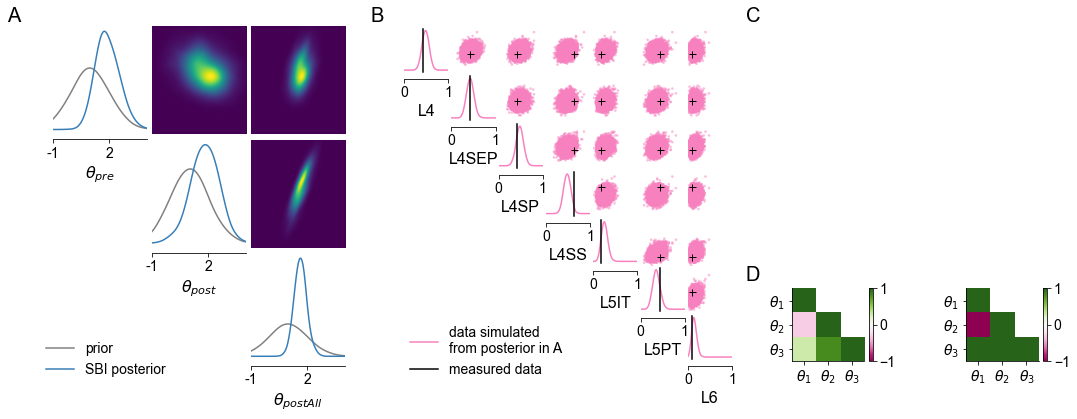

In [57]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 3, wspace=0.2, hspace=0, width_ratios=[.33, .37, .3])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(ndims, ndims, wspace=0.05, hspace=0.05)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# center column
num_plots = 7
center_grid = outer_grid[0, 1].subgridspec(num_plots, num_plots, wspace=0.07, hspace=0)
ax2 = center_grid.subplots()

# right column
right_grid = outer_grid[0, 2].subgridspec(2, 1, wspace=0., hspace=0.3, height_ratios=[.75, .25])

corr_subgrid = right_grid[1, 0].subgridspec(1, 2, wspace=.9, hspace=0.0)
ax3 = corr_subgrid.subplots()

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "SBI posterior"], 
           bbox_to_anchor=(-.2, -1.8), 
           loc=2)

fig, ax2 = pairplot(xos[:num_samples], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    hist_diag=dict(bins=10),
                    points_offdiag=posterior_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="scatter",
                    diag="kde",
                    kde_diag=dict(bins=num_bins, bw_method=bw_method),
                    scatter_offdiag=dict(s=7, alpha=0.5),
                    contour_offdiag=dict(levels=[0.99]),
                    samples_colors=[colors[3]],
                    axes=ax2, 
                    fig=fig,
                   )
plt.sca(ax2[0, 0])
plt.legend(["data simulated \nfrom posterior in A", "measured data"], 
           bbox_to_anchor=(-.15, -5.), 
           loc=2)

# Correlation matrices
plt.sca(ax3[0])
im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])
plt.yticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])

plt.sca(ax3[1])
im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)])
plt.yticks([0, 1, 2], [rf"$\theta_{i+1}$" for i in range(3)]);


# Add Letters.
weight = "regular"
fontsize = 20
y = 0.91
fig.text(.09, y, "A", fontsize=fontsize, fontweight=weight)
fig.text(.37, y, "B", fontsize=fontsize, fontweight=weight)
fig.text(.66, y, "C", fontsize=fontsize, fontweight=weight)
# fig.text(.79, y, "D", fontsize=fontsize, fontweight=weight);
fig.text(.66, .31, "D", fontsize=fontsize, fontweight=weight);

In [59]:
fig.savefig("figure3_literatureInference_Default_ss50_gaussian_v2.png", dpi=300, bbox_inches='tight')

## Posterior projection in 3D

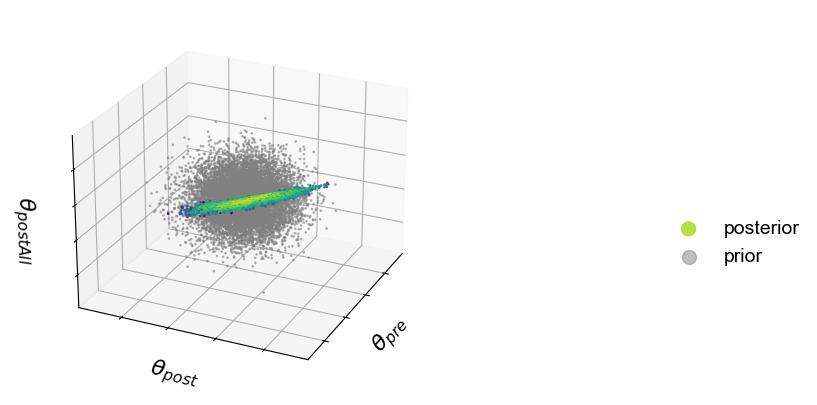

In [120]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(10, 5))
samples = posterior.sample((10000,), x=xo, show_progress_bars=False)
ax.scatter(*samples.T, 
                          c=posterior.log_prob(samples), 
#             cmap="viridis",
                          alpha=0.9, s=1, label="posterior")
ax.scatter(*prior.sample((10000,)).T, 
#                           c=posterior.log_prob(osamples), 
                          c="grey",
                          alpha=0.5, s=1, label="prior")
plt.legend(bbox_to_anchor=(2.0, 0.5), markerscale=10.0)
ax.view_init(25, 25)
# from matplotlib import rcParams
rcParams['axes.labelpad'] = 0.01;
for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(r"$\theta_{pre}$")
ax.set_ylabel(r"$\theta_{post}$")
ax.set_zlabel(r"$\theta_{postAll}$");
fig.savefig("figure3_posterior3d.png", dpi=300, bbox_inches='tight')

In [11]:
posterior.map(x=xo, show_progress_bars=False)

tensor([1.6201, 2.0726, 1.6501])

In [12]:
thos.mean(0)

tensor([1.9134, 1.8199, 1.6404])

In [66]:
# sem
thos.std(0) / np.sqrt(thos.shape[0])

tensor([0.0063, 0.0075, 0.0033])

In [121]:
thos.var(0)

tensor([0.3955, 0.5585, 0.1074])

In [127]:
thos.std(0)**2

tensor([0.3955, 0.5585, 0.1074])

In [131]:
idx = torch.argsort(thos, dim=0)[:, 1]

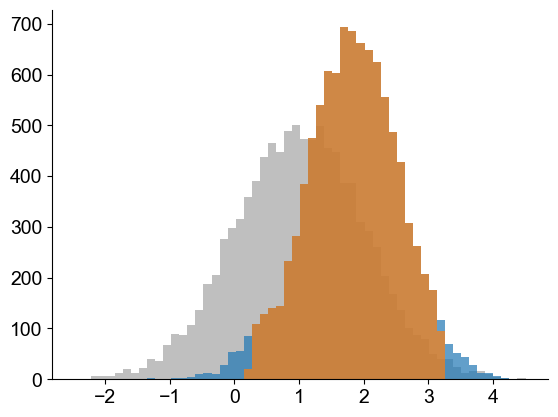

In [149]:
_, bins, _ = plt.hist(ths[:, 1].numpy(), color="gray", alpha=0.5, bins="auto")
plt.hist(thos[idx, 1].numpy(), bins=bins, alpha=0.7);
ttt = thos[idx, 1][250:-250]
plt.hist(ttt.numpy(), bins=bins, alpha=0.7);

In [142]:
ttt.min(), ttt.max()

(tensor(0.2425), tensor(3.2425))

In [14]:
posterior.set_default_x(xo)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])),
               x_shape=torch.Size([1, 7]))
               

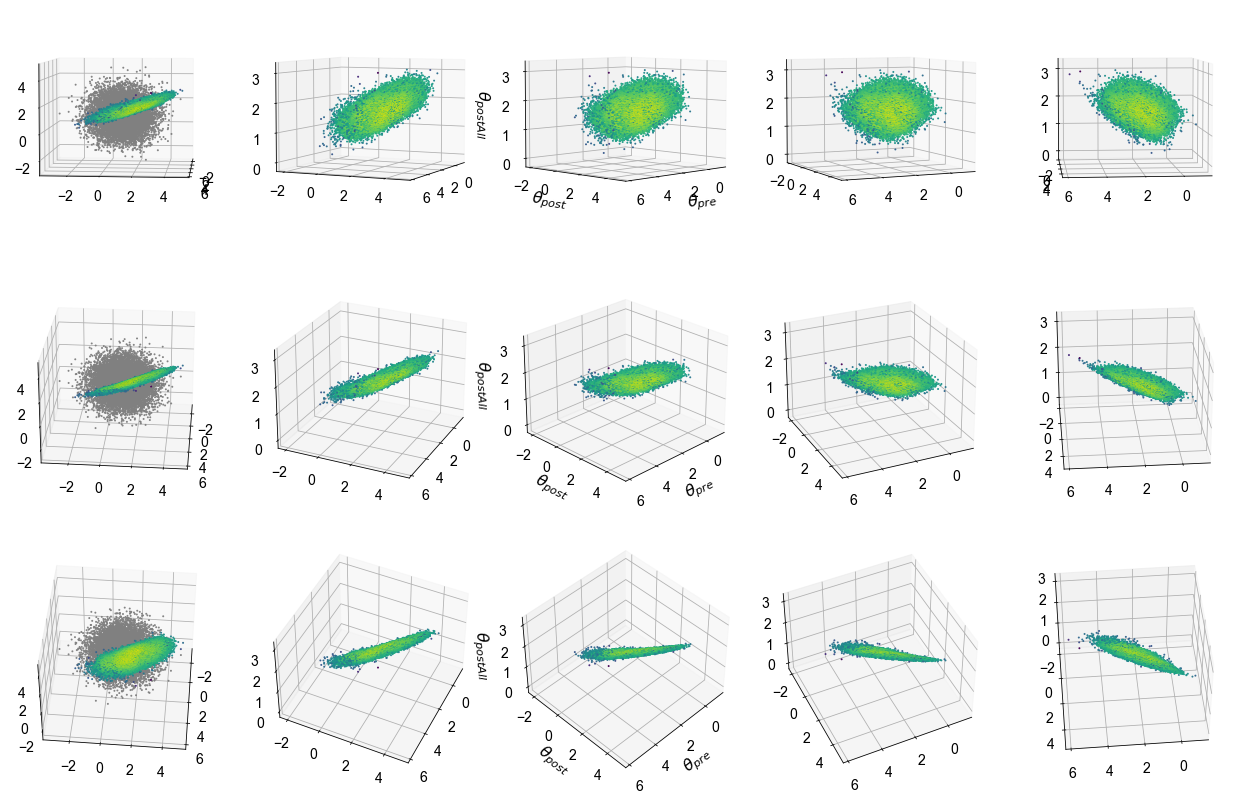

In [16]:
num_plots = 5
fig, axs = plt.subplots(3, num_plots, subplot_kw={"projection": "3d"}, figsize=(18, 12))

samples = prior.sample((10000,))
osamples = posterior.sample((100000,), show_progress_bars=False)
for j, ang in enumerate([5, 25, 45]):
    for i, angx in enumerate(np.arange(5, 100, 20)):
        ax = axs[j, i]
        if i == 0:
            surf = ax.scatter(samples[:, 0], samples[:, 1],samples[:, 2], 
#                               c=prior.log_prob(samples),
                              c="grey",
                              alpha=0.9, s=1, )
        surf = ax.scatter(osamples[:, 0], osamples[:, 1], osamples[:, 2], 
                          c=posterior.log_prob(osamples), 
#                           c="C1",
                          alpha=0.9, s=1)
        if i == 2:
            ax.set_xlabel(r"$\theta_{pre}$")
            ax.set_ylabel(r"$\theta_{post}$")
            ax.set_zlabel(r"$\theta_{postAll}$")
        ax.view_init(ang, angx)
plt.tight_layout();